## **INTRODUÇÃO**

---

Neste notebook, implementamos um algoritmo de **regressão simbólica** com o objetivo de encontrar uma função sigmoidal utilizando **[programação genética](https://medium.com/analytics-vidhya/python-symbolic-regression-with-gplearn-cbc24dbbc271)** [1].

A regressão simbólica é uma técnica poderosa dentro do aprendizado de máquina que busca encontrar expressões matemáticas analíticas que melhor descrevam a relação entre variáveis de entrada e saída. Diferente de abordagens como regressão linear ou redes neurais, a regressão simbólica não parte de um modelo fixo, ela explora uma grande variedade de estruturas possíveis, o que a torna especialmente útil quando a forma da função subjacente é desconhecida.

Para realizar essa tarefa, empregamos Programação Genética (GP), que é uma técnica baseada em algoritmos genéticos, onde os indivíduos da população são representações de árvores de expressões matemáticas (*Primitive Trees*). Essas expressões evoluem ao longo de gerações por meio de seleção, cruzamento e mutação entre os indivíduos da população, com o objetivo de minimizar o erro entre a expressão gerada e os dados-alvo.

A implementação foi feita utilizando o módulo [DEAP (Distributed Evolutionary Algorithms in Python)](https://deap.readthedocs.io/) [2], que fornece uma estrutura flexível e poderosa para construção de algoritmos evolutivos. O DEAP facilita a definição de operadores genéticos personalizados, tipos de indivíduos e avaliação de fitness, sendo uma excelente escolha para aplicações com GP.

Neste trabalho, a função-alvo que buscamos aproximar é a **função sigmoide**:

$$
f(x) = \frac{1}{1 + e^{-x}}
$$

Esta função foi escolhida por ser uma função de ativação amplamente utilizada em redes neurais, além de possuir uma forma contínua, suave e não-linear, que são características que a tornam um bom desafio para a regressão simbólica. Nosso objetivo é fazer com que o algoritmo evolua até encontrar uma expressão matemática que se aproxime bem da forma da sigmoide em um intervalo definido de \( x \).

---

## **AUTORES E CONTRIBUIÇÕES**

**Autores:**

* Caio Matheus Leão Dantas
* Joana de Medeiros Oliveira Hulse Molinete

**Contribuições:** Toda a discussão acerca do problema, entendimento e desenvolvimento do código foi realizada em conjunto pelos autores e de forma concomitante.

---

## **CÓDIGO**

O primeiro passo realizado é a importação das bibliotecas que serão utilizadas no decorrer do código:

In [1]:
import random 
import operator
import math
import numpy as np
import matplotlib.pyplot as plt
from functools import partial 
from deap import algorithms, base, creator, tools, gp
from deap.algorithms import eaSimple

E a definição dos hiperparâmetros utilizados no algoritmo genético:

In [2]:
TAMANHO_POPULACAO = 150
NUM_GERACOES = 100
CHANCE_DE_CRUZAMENTO = 0.1
CHANCE_DE_MUTACAO = 0.05
TAMANHO_TORNEIO = 3

Definimos funções de "proteção" para que o algoritmo não enfrente problemas com divisões por zero ou exponenciais com resultados muito elevados:

In [3]:
def protectedDiv(dividendo, divisor):
    try:
        return dividendo / divisor
    except ZeroDivisionError:
        return 1
    
def protectedExp(x):
    try:         
        return math.exp(x)     
    except OverflowError:         
        return float("inf") ### retornar infinito sem quebrar o código

E como primeiro passo do algoritmo em si, realizamos a definição das operações matemáticas que poderemos utilizar durante o código, denominadas "operações primitivas". Foram adotadas as operações de:
* `Soma` e `Subtração`
* `Multiplicação` e `Divisão`
* `Negação`
* `Exponecial` ($e^x$)
* `Constantes positivas, negativas ou nulas`

In [4]:
op_primitivas = gp.PrimitiveSet("MAIN", 1)
op_primitivas.addPrimitive(operator.add, 2)
op_primitivas.addPrimitive(operator.sub, 2)
op_primitivas.addPrimitive(operator.mul, 2)
op_primitivas.addPrimitive(protectedDiv, 2)
op_primitivas.addPrimitive(operator.neg, 1)
op_primitivas.addPrimitive(protectedExp, 1, name = "exp")
op_primitivas.addEphemeralConstant("limites101", partial(random.randint, -1, 1))
op_primitivas.renameArguments(ARG0 = "x")

A partir da análise do problema, adotamos uma estratégia de buscar a minimização por meio da busca pelo fitness mínimo e definimos o formato de `árvore primitiva`* para cada indivíduo, de modo a criarmos "fórmulas possíveis" como os indivíduos do nosso algoritmo:

###### * O conceito e funcionamento de uma árvore primitiva pode ser melhor explorado na Referência 4 e será melhor discutido na seção "Conclusão".

In [5]:
creator.create("FitnessMin", base.Fitness, weights = (-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness = creator.FitnessMin)

Em seguida, definimos uma *toolbox* para que possamos registrar cada uma das funções que iremos utilizar, tais como a criação de um indivíduo e a formação de uma população: 

In [6]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset = op_primitivas, min_ = 1, max_ = 2)
toolbox.register("individuo", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("populacao", tools.initRepeat, list, toolbox.individuo)
toolbox.register("compila", gp.compile, pset = op_primitivas)

E, dado que o objetivo do nosso algoritmo parte do intuito de desenvolver uma `regressão simbólica`, achamos a relação entre cada possível indivíduo da população e a nossa função buscada, de modo a possuirmos uma relação que pode ser descrita como:

$$
Erro = Indivíduo - \frac{1}{1 + e^{-x}}
$$

In [7]:
def RegSimb(individuo, pontos):
    funcao = toolbox.compila(expr = individuo)
    erros = ((funcao(x) - 1 / (1 + protectedExp(-x))) ** 2 for x in pontos)
    return math.fsum(erros)/len(pontos),

A partir do momento que possuímos uma função objetivo, adicionamos na nossa *toolbox* as funções de `avaliação do modelo`, `seleção por torneio`, `cruzamento de ponto simples` e `mutação uniforme`, que serão utilizados no desenvolvimento do nosso algoritmo:

In [8]:
toolbox.register("evaluate", RegSimb, pontos = [x/10. for x in range(-10,10)]) # então temos um espaço de busca de pontos que vai de -1 até 1 com passos de 0,1 em 0,1
toolbox.register("select", tools.selTournament, tournsize = TAMANHO_TORNEIO)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_ = 0, max_ = 2)
toolbox.register("mutate", gp.mutUniform, expr = toolbox.expr_mut, pset = op_primitivas)

Além disso, no intuito de impedir que a árvore primitiva se torne muito extensa após os cruzamentos e mutações, é imposto um valor limite de altura, impedindo a margem para explosão do modelo que poderia acontecer: 

In [9]:
toolbox.decorate("mate", gp.staticLimit(key = operator.attrgetter("height"), max_value = 17))
toolbox.decorate("mutate", gp.staticLimit(key = operator.attrgetter("height"), max_value = 17))

Com "tudo pronto", vamos agora para o nosso processo evolutivo. Realizamos a criação da nossa `população` e `hall da fama` para armazenamento do melhor indivíduo, além de definirmos as estatísticas que iremos computar do modelo. Assim, utilizamos a função `eaSimple` para realizar a evolução do algoritmo pelo número desejado de gerações e realizar os passos de cruzamento e mutação. 

In [10]:
def main():
    random.seed(42)
    
    pop = toolbox.populacao(n=TAMANHO_POPULACAO)
    hall_da_fama = tools.HallOfFame(1)
    
    fitness = tools.Statistics(lambda ind: ind.fitness.values)
    tamanho = tools.Statistics(len)
    m_stats = tools.MultiStatistics(fitness = fitness, size = tamanho)
    m_stats.register("mean", np.mean)
    m_stats.register("std", np.std)
    m_stats.register("min", np.min)
    m_stats.register("max", np.max)
    
    populacao, log = eaSimple(
        pop, 
        toolbox,
        cxpb = CHANCE_DE_CRUZAMENTO,
        mutpb = CHANCE_DE_MUTACAO,
        ngen = NUM_GERACOES,
        stats = m_stats,
        halloffame = hall_da_fama,
        verbose = True
    )
    
    return {
        "populacao": populacao,
        "log": log,
        "hall_da_fama": hall_da_fama,
        "melhor_individuo": hall_da_fama[0],
        "melhor_fitness": hall_da_fama[0].fitness.values[0]
    }

A partir da evolução realizada pelo nosso algoritmo, podemos explicitar as estatísticas computadas em cada uma das gerações por meio do *`verbose = True`*:

In [11]:
if __name__ == "__main__":
    resultados = main()
    log = resultados["log"]
    melhor_individuo = resultados["melhor_individuo"]
    melhor_fitness = resultados["melhor_fitness"]

   	      	                        fitness                        	                      size                     
   	      	-------------------------------------------------------	-----------------------------------------------
gen	nevals	gen	max    	mean   	min      	nevals	std    	gen	max	mean	min	nevals	std    
0  	150   	0  	65.1494	2.30024	0.0190172	150   	6.10265	0  	7  	3.74	2  	150   	1.53809
1  	23    	1  	7.36527	0.490555	0.0190172	23    	0.876675	1  	8  	4.16667	2  	23    	1.70652
2  	18    	2  	3.15354	0.279559	0.0190172	18    	0.436612	2  	7  	4.44   	2  	18    	1.49434
3  	27    	3  	6.86599	0.359028	0.0190172	27    	1.05423 	3  	10 	4.28667	1  	27    	1.52025
4  	26    	4  	47.6373	1.29117 	0.0190172	26    	6.60353 	4  	9  	4.5    	2  	26    	1.29486
5  	18    	5  	6.86599	0.0988828	0.0190172	18    	0.567338	5  	7  	4.75333	2  	18    	0.871295
6  	18    	6  	6.86599	0.115553 	0.0190172	18    	0.783458	6  	11 	5.04667	3  	18    	0.592584
7  	26    	7  	16.117 	0.252519 

E analisar o desenvolvimento do melhor fitness obtido em função das gerações:

Com isso, obtemos um melhor indíviduo baseado no seu fitness (o menor, já que estamos lidando com um problema de minimização):

In [13]:
print("Melhor indivíduo:", resultados["melhor_individuo"])
print("Fitness:", resultados["melhor_fitness"])

Melhor indivíduo: protectedDiv(1, add(1, exp(neg(x))))
Fitness: 0.0


E podemos comparar a função real com a que visamos a obter com o modelo de forma gráfica, de modo a avaliar de forma analítica o quão "parecidas" as funções estão:

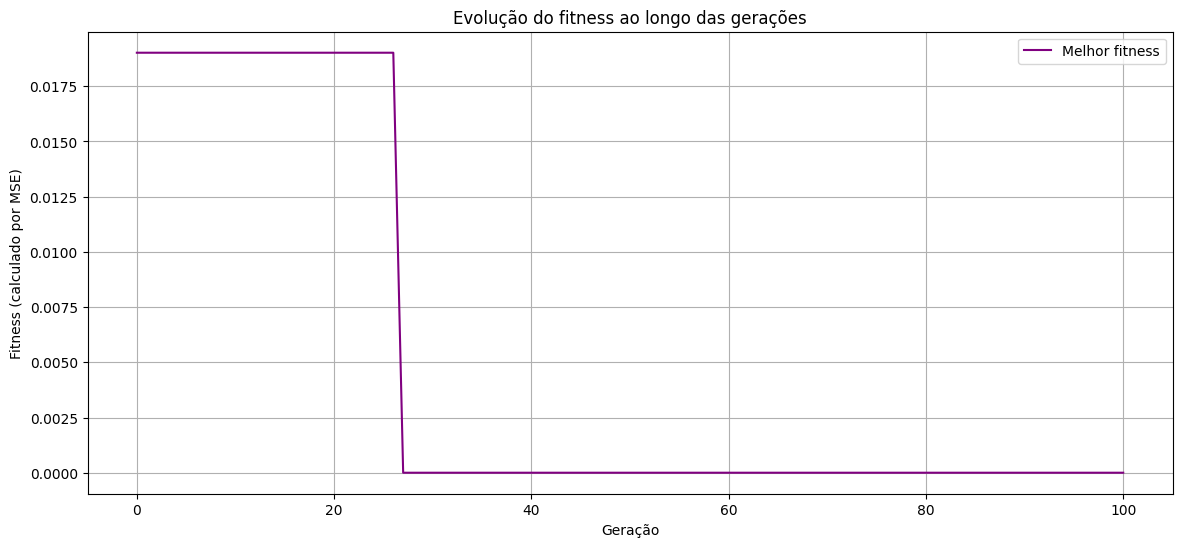

In [12]:
geracao = log.select("gen")
min_fitness = log.chapters["fitness"].select("min")

plt.figure(figsize=(14, 6))
plt.plot(geracao, min_fitness, label="Melhor fitness", color = "purple")
plt.xlabel("Geração")
plt.ylabel("Fitness (calculado por MSE)")
plt.title("Evolução do fitness ao longo das gerações")
plt.legend()
plt.grid()
plt.show()

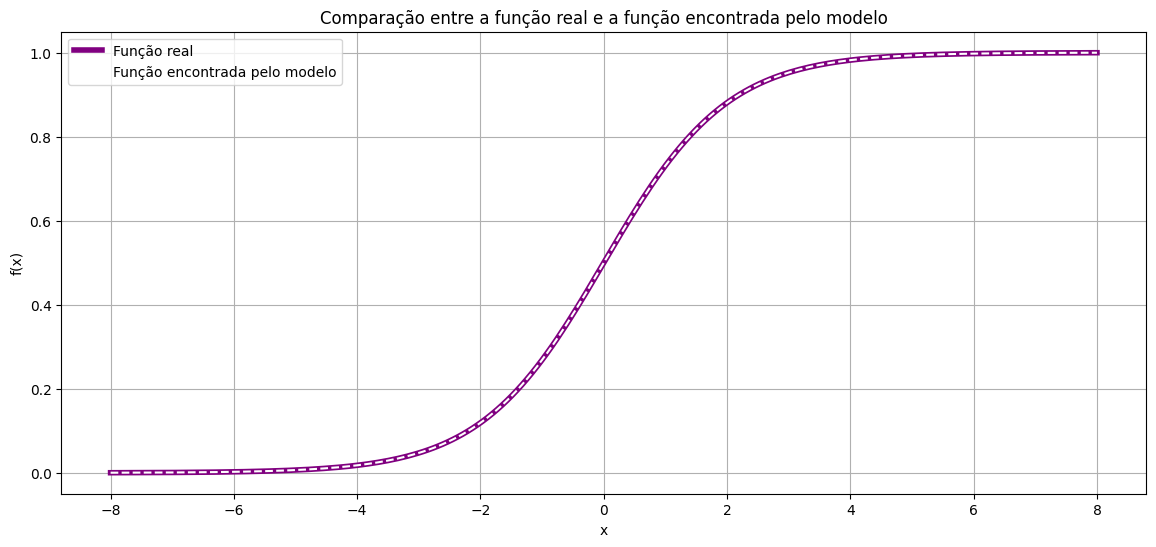

In [14]:
funcao_encontrada = toolbox.compila(expr=melhor_individuo)
x_vals = np.linspace(-8, 8, 200)
y_real = [1 / (1 + math.exp(-x)) for x in x_vals]
y_prev = [funcao_encontrada(x) for x in x_vals]

plt.figure(figsize=(14, 6))
plt.plot(x_vals, y_real, label="Função real", color="purple", linewidth=4)
plt.plot(x_vals, y_prev, label="Função encontrada pelo modelo", linestyle="--", color="white")
plt.title("Comparação entre a função real e a função encontrada pelo modelo")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)
plt.show()

---

## **CONCLUSÃO**

Neste trabalho, utilizamos uma abordagem de Programação Genética (GP) como técnica de regressão simbólica para aproximação da função sigmoide, representada por $f(x) = \frac{1}{1 + e^{-x}}$. A partir dessa abordagem, através de uma evolução por gerações, o algoritmo foi capaz de encontrar expressões matemáticas válidas que, quando avaliadas pelo seu MSE, se aproximaram ou até eram equivalentes à própria função alvo.
 
Os indivíduos evoluídos na atividade foram representados por árvores primitivas, dado que o problema abordado trabalhava com expressões e os nós internos e folhas dessas árvores representam, respectivamente, operações matemáticas e variáveis ou constantes. Com isso, adotamos essa forma de representação muito utilizada na Programação Genética, pois permite que as expressões simbólicas sejam manipuladas de forma estruturada e coerente.
 
Com isso em mente, pudemos perceber, ao final das gerações, não apenas a redução consistente do erro, como também a obtenção de uma função simbólica igual a desejada, demonstrando a capacidade do método de gerar soluções efetivas e interpretáveis e a confirmação de aptidão do algoritmo apresentado.

---

## **REFERÊNCIAS**

**[1]** CASTIGLIONI, Andrea. Python Symbolic Regression with gplearn: how to discover analytical relationships in your data, 2020. Disponível em: https://medium.com/analytics-vidhya/python-symbolic-regression-with-gplearn-cbc24dbbc271.

**[2]** Symbolic Regression Problem: Introduction to GP. DEAP. Disponível em: https://deap.readthedocs.io/en/master/examples/gp_symbreg.html

**[3]** CASSAR, Daniel. Redes Neurais e Algoritmos Genéticos. 2025. Material de Aula.

**[4]** Symbolic Regression Problem: Introduction to GP — DEAP 1.4.3 documentation. Disponível em: https://deap.readthedocs.io/en/master/examples/gp_symbreg.html.

**[5]** WIRSANSKY, E. Hands-On Genetic Algorithms with Python: Apply genetic algorithms to solve real-world AI and machine learning problems. 2. ed. Birmingham, England: Packt Publishing. 2024.

**[6]** Genetic programming — DEAP 1.4.1 documentation. Disponível em: https://deap.readthedocs.io/en/stable/tutorials/advanced/gp.html.